# Correcting counts in nasopharyngal carcinoma datasets using MNNCorrection model

In this example, we will use *transmorph* to integrate nasopharyngal carcinoma (NC) datasets from fourteen patients, gathered in [1]. These datasets contain in total more than 60k cells, which are all associated with a cell type annotation among *B cell*, *endothelial*, *epithelial* and *macrophage*, *malignant*, *NK cell*, *plasma* and *T cell*. This data bank is challenging for several reasons: large number of batches and cell types, high number of cells, many batches missing some cell types. In addition, we would like to perform a corrective integration, where all datasets end up embedded in a common gene space, which can subsequently be used in algorithms which necessitates a "raw" feature space such as Independent Component Analysis. 

We use one of our built-in models, **MNNCorrection**, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2] followed by a nearest-neighbors smoothed linear correction in the largest common genes space. This model requires a dataset to be chosen as a reference, all the others will be corrected according to this choice. The reference dataset should ideally contain at least a few cells of every cell type.

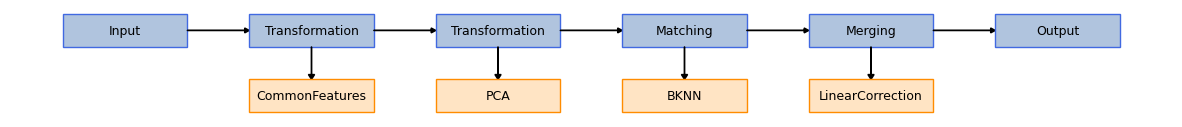

In [1]:
from transmorph.models import MNNCorrection
from transmorph.utils.plotting import plot_model

model = MNNCorrection() 
plot_model(model)

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. NC databank contains 14 datasets in the AnnData format, each expressed within its 10,000 most variable genes space. Cells are annotated by the .obs key "class". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [2]:
from transmorph.datasets import load_chen_10x

# Format: {patient_label -> AnnData}
chen_10x = load_chen_10x()

databank_api > Loading bank chen_10x.
databank_api > Bank chen_10x successfully loaded.


Let us choose a reference dataset, using transmorph plotting tools. We display the cell type distribution across batches in order to select the most comprehensive dataset in terms of cell types.

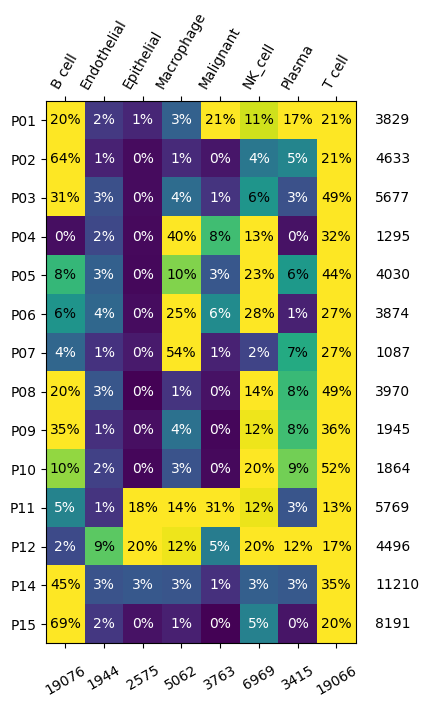

In [3]:
# Displaying cell type distribution across batches

from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(chen_10x, label="class")

P12 seems to be a reasonable reference choice, as it contains cells from all types, and a relatively high number of cells.

### Plotting initial datasets

The scatter_plot method can be used to display a low dimensional representation of a set of datasets. It requires first a dimensionality reduction, which can be applied using our framework, we will use the default reducer, UMAP [3]. Computing a UMAP representation can take some time for large datasets, but it can then be cached to avoid recomputing every time.

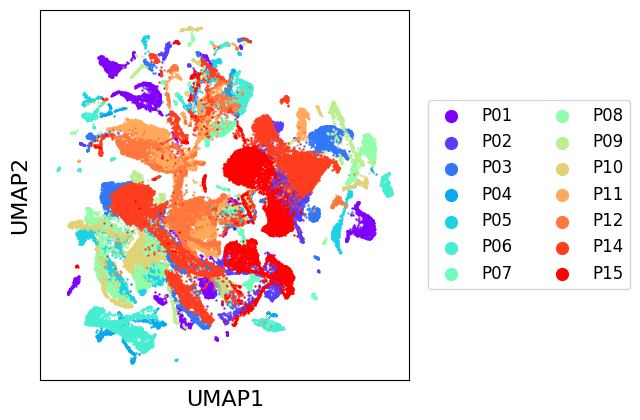

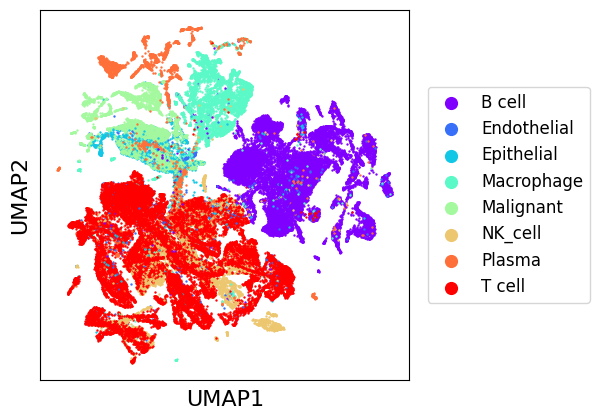

In [4]:
from transmorph.utils.plotting import scatter_plot, reduce_dimension

reduce_dimension(chen_10x, output_obsm="tr_umap")

# use_cache=True allows to avoid recomputing a UMAP representation for each plot
scatter_plot(chen_10x, use_rep="tr_umap")
scatter_plot(chen_10x, color_by="class", use_rep="tr_umap")

As we can see, there seems to be a general natural clustering of cell types. Though, we observe very important variations between batches, that MNNCorrection will aim to correct. We can assess integration quality using LISI introduced with Harmony [4], which gives an estimation of the number of different labels in the neighborhood of a cell. We use "LISI-batch" with batches as labels to evaluate mixing (higher is better mixed), and "LISI-class" with cell types as labels to evaluate cell types separation (lower is more pure).

In [5]:
from transmorph.stats.lisi import lisi

datasets = list(chen_10x.values())
lisi_batch_bef = lisi(datasets) # By default, gene representation is used
lisi_class_bef = lisi(datasets, obs="class")

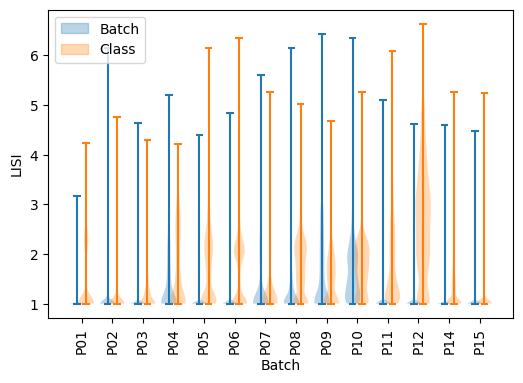

In [7]:
# Plotting LISI as violin plots

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    
positions = np.arange(len(datasets))

labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_batch_bef, positions=positions - .15), "Batch")
add_label(plt.violinplot(lisi_class_bef, positions=positions + .15), "Class")
plt.xticks(positions, chen_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI")

plt.legend(*zip(*labels), loc=2)
pass

As we can see, except for P10 all batches have only same-batches cells in their neighborhood, and cell type purity is quite decent except for P05, P06, P08, P10 and P12. The goal of integration is to increase LISI-batch while keeping LISI-class as low as possible.

### Dataset integration using MNNCorrection

**MNNCorrection** combines a mutual nearest neighbors step with a linear correction step in gene space, supported with a nearest neighbors smooting. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects and a reference AnnData. The method will add a .obsm["transmorph"] entry, corresponding to the integrated view computed.
**This model embeds all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [8]:
model.transform(chen_10x, reference=chen_10x['P12'])

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 14 datasets, 61870 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#0.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#1.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#2.
MNN_CORRECTION > Running layer LAYER_MATCHING#3.
LAYER_MATCHING#3 > Calling matching MATCHING_MNN.
MNN_CORRECTION > Running layer LAYER_MERGING#4.
LAYER_MERGING#4 > Running merging MERGING_LINEAR_CORRECTION...
MNN_CORRECTION > Running layer LAYER_OUTPUT#5.
MNN_CORRECTION > Terminated. Total embedding shape: (61870, 924)
MNN_CORRECTION > Results have been written in AnnData.obsm['transmorph'].


### Integration analysis with LISI

As we can see, 924 genes have been chosen for the embedding. First, let us display in a UMAP view datasets embedded in common gene space, passing the entry "transmorph" to reduce_dimension. Gene names can be accessed as a pandas Index in the attribute model.gene_names.

In [9]:
model.embedding_features

Index(['ABCA1', 'ABCB1', 'ABHD5', 'ABR', 'AC003681.1', 'AC004585.1',
       'AC004817.3', 'AC005070.3', 'AC005224.2', 'AC005332.3',
       ...
       'ZNF683', 'ZNF699', 'ZNF790-AS1', 'ZNF80', 'ZNF83', 'ZNF831', 'ZNF92',
       'ZSCAN16-AS1', 'ZSCAN32', 'ZWINT'],
      dtype='object', length=924)

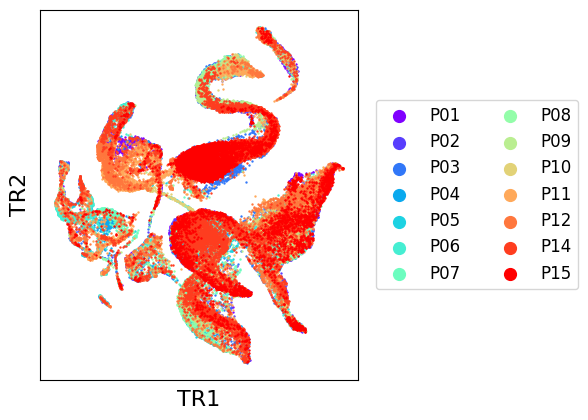

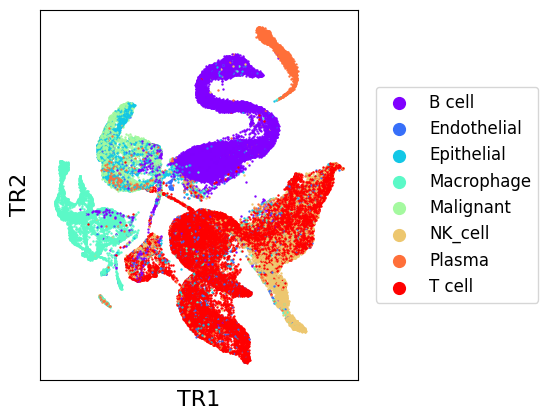

In [12]:
from transmorph.utils.plotting import reduce_dimension, scatter_plot

reduce_dimension(chen_10x, reducer="umap", input_obsm="transmorph", output_obsm="transmorph_umap")

scatter_plot(chen_10x, use_rep="transmorph_umap", xlabel="TR1", ylabel="TR2")
scatter_plot(chen_10x, use_rep="transmorph_umap", color_by="class", xlabel="TR1", ylabel="TR2")

As we can see, **MNNCorrection** seems to have greatly improved the mixing between batches, while reasonably conserving distinction between cell types. We can confirm this by comparing with post-transmorph LISI.

In [13]:
from transmorph.stats.lisi import lisi

datasets = list(chen_10x.values())
lisi_batch_aft = lisi(datasets, obsm="transmorph")
lisi_class_aft = lisi(datasets, obsm="transmorph", obs="class")

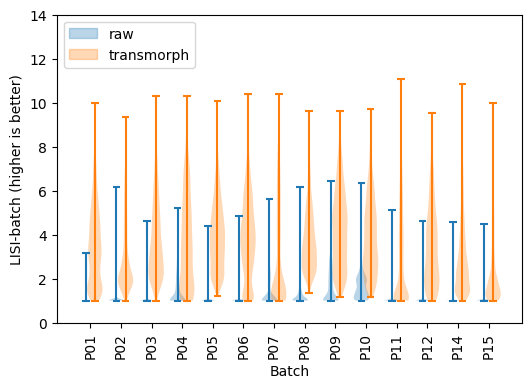

In [14]:
# LISI-batch (higher is better)
labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_batch_bef, positions=positions - .15), "raw")
add_label(plt.violinplot(lisi_batch_aft, positions=positions + .15), "transmorph")
plt.ylim(0, len(datasets))
plt.xticks(positions, chen_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI-batch (higher is better)")

plt.legend(*zip(*labels), loc=2)
pass

LISI-batch has greatly improved using transmorph, meaning batches are now way better mixed.

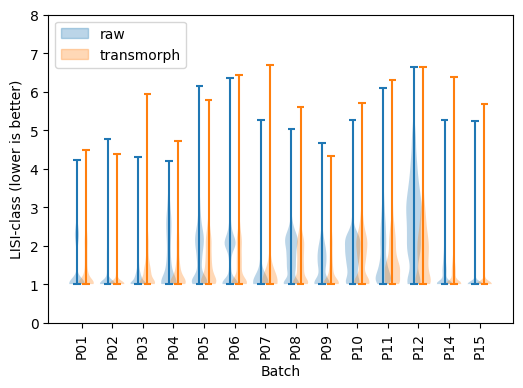

In [15]:
# LISI-class (lower is better)
labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_class_bef, positions=positions - .15), "raw")
add_label(plt.violinplot(lisi_class_aft, positions=positions + .15), "transmorph")
plt.ylim(0, 8)
plt.xticks(positions, chen_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI-class (lower is better)")

plt.legend(*zip(*labels), loc=2)
pass

LISI-class has also consistently decreased using transmorph except for P10 and P12, meaning cell types are better separated.

## References

[1] Chen, Y. P., Yin, J. H., Li, W. F., Li, H. J., Chen, D. P., Zhang, C. J., ... & Ma, J. (2020). Single-cell transcriptomics reveals regulators underlying immune cell diversity and immune subtypes associated with prognosis in nasopharyngeal carcinoma. Cell research, 30(11), 1024-1042.

[2] Haghverdi, Laleh, et al. *Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.* **Nature biotechnology** 36.5 (2018): 421-427.

[3] Becht, Etienne, et al. *Dimensionality reduction for visualizing single-cell data using UMAP.* **Nature biotechnology** 37.1 (2019): 38-44.

[4]  Korsunsky, Ilya, et al. *Fast, sensitive and accurate integration of single-cell data with Harmony.* **Nature methods** 16.12 (2019): 1289-1296.
